In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.nn.functional import softmax, interpolate
from PIL import Image
from torchvision import models, transforms
# from torchvision.models import resnet18
from torchvision.transforms.functional import resize, to_pil_image
from torchinfo import summary

from torchcam.methods import CAM, ScoreCAM, GradCAM, GradCAMpp, SmoothGradCAMpp, LayerCAM
from torchcam.utils import overlay_mask

import pandas as pd

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import os

Approach:
- obtain class activation map of image
- Apply a threshold to filter only highly activated pixels - segmentation mask
- Apply KMeans to obtain color distribution and most dominant colour 
- Apply KNNClassifier to map dominant color to the target color category

# Using a pretrained Resnet model

In [2]:
model = models.resnet18(pretrained=True).eval()

tsfm = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [3]:
cam_extractor = LayerCAM(model)

In [ ]:
img = Image.open("../data/mc/train/Apparel/11276.jpg").convert("RGB")

# preprocessing image
input_tensor = resize(img, (224, 224))
convert = transforms.ToTensor()
input_tensor = convert(input_tensor)
input_tensor = input_tensor

# feeding image to the model
out = model(input_tensor.unsqueeze(0))

# Retrieving the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

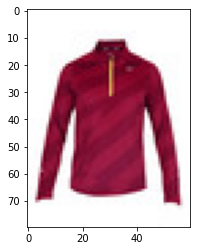

In [9]:
plt.imshow(img)

In [10]:
# generating segmentation mask from cam
scores = cams[0].cpu()
resized_scores = resize(to_pil_image(scores.squeeze(0)), size=(224, 224))
scores_array = np.array(resized_scores)
norm_scores = scores_array/255
seg_mask = np.where(norm_scores > 0.8, 1, 0)

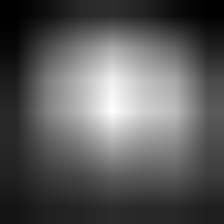

In [11]:
resized_scores

In [12]:
img_array = np.array(to_pil_image(input_tensor.cpu()))
masked_image = img_array[seg_mask == 1]

In [13]:
# applying KMeans to obtain most dominant colors
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(masked_image)
colors = kmeans.cluster_centers_
colors

array([[132.0952381 ,  12.33256528,  47.42319508],
       [186.33333333, 116.90151515,  74.90909091],
       [151.2473029 ,  22.29626556,  58.28962656]])

# Using the Category Classification model

In [2]:
# recreating custom model architecture
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mc_model = models.resnet50(pretrained=True).to(device)
    
mc_model.fc = torch.nn.Sequential(
               torch.nn.Linear(2048, 128),
               torch.nn.ReLU(),
               torch.nn.Linear(128, 7)).to(device)

mc_model.load_state_dict(torch.load("../models/mc_model.pth"))

<All keys matched successfully>

In [3]:
mc_model.eval()

tsfm = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.CenterCrop(112),
    transforms.ToTensor() 
])

In [4]:
cam_extractor = LayerCAM(mc_model)

In [54]:
# Get your input
img = Image.open("../data/myntradataset/images/39386.jpg").convert("RGB")

input_tensor = resize(img, (224, 224))
# convert = transforms.ToTensor()
input_tensor = tsfm(input_tensor)
input_tensor = input_tensor.to(device)

out = mc_model(input_tensor.unsqueeze(0))

cams = cam_extractor(out.squeeze(0).argmax().item(), out)

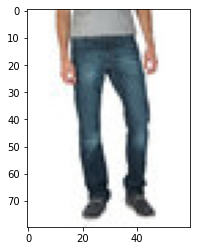

In [55]:
plt.imshow(img)

In [56]:
# generating segmentation mask from cam
scores = cams[0].cpu()
resized_scores = resize(to_pil_image(scores.squeeze(0)), size=(112, 112))
scores_array = np.array(resized_scores)
norm_scores = scores_array/255
seg_mask = np.where(norm_scores > 0.8, 1, 0)

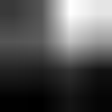

In [57]:
resized_scores 

In [58]:
img_array = np.array(to_pil_image(input_tensor.cpu()))
masked_image = img_array[seg_mask == 1]

In [59]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(masked_image)
colors = kmeans.cluster_centers_
colors

array([[ 49.39858907,  69.82186949,  82.58906526],
       [ 74.53433836, 101.23953099, 113.90619765],
       [205.1875    , 191.02083333, 189.484375  ]])

The labels are:  [0 1 2]
Count of  items:  [567 597 192]


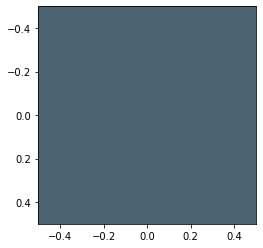

In [60]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
print("The labels are: ",unique)
print("Count of  items: ",counts)

# Find the most dense cluster label
idx = np.where(counts == counts.max())[0]

# Pick the most dense cluster centroid
s = tuple(map(int,kmeans.cluster_centers_[idx][0]))

plt.imshow([[s]])

# Mapping rgb values to color categories

In [20]:
# using only main colors
color_map = {
    (0, 0, 0): "Black",
    (255, 255, 255): "White",
    (0, 0, 255): "Blue",
    (165, 42, 42): "Brown",
#     (84, 84, 84): "Grey",
    (255, 0, 0): "Red",
    (0, 255, 0): "Green",
    (255, 130, 171): "Pink",
    (0, 0, 128): "Navy Blue",
    (191, 64, 191): "Purple",
#     (192, 192, 192): "Silver",
    (255, 255, 0): "Yellow",
#     (245,245,220): "Beige",
#     (255,215,0): "Gold",
#     (176,48,96): "Maroon",
    (255,127,0): "Orange",
    (128,128,0): "Olive",
#     (253,245,230): "Cream",
#     (79,79,79): "Charcoal",
#     Steel
#     Multi
#     (255,193,193): "Peach",
#     (255,250,240): "Off White",
#     (255,235,205): "Skin",
#     (203, 165, 214): "Lavender",
#     grey melange
#     (74,118,110): "Khaki",
#     (255,0,255): "Magenta",
#     (0,128,128): "Teal",
#     (210,180,140): "Tan",
#     (255,193,37): "Mustard",
#     bronze
#     (184,115,51): "Copper",
#     (0,197,205): "Turquoise Blue",
#     (205,79,57): "Rust",
#     (140,23,23): "Burgundy",
#     metallic
#     (107,66,38): "Coffee Brown",
#     (187,133,171): "Mauve",
#     rose
#     nude
#     Sea Green            
#     Mushroom Brown         
#     Taupe                  
#     Lime Green             
#     Fluorescent Green 
}

In [21]:
color_df = pd.Series(color_map).reset_index()
color_df

,level_0,level_1,level_2,0
0,0,0,0,Black
1,255,255,255,White
2,0,0,255,Blue
3,165,42,42,Brown
4,255,0,0,Red
5,0,255,0,Green
6,255,130,171,Pink
7,0,0,128,Navy Blue
8,191,64,191,Purple
9,255,255,0,Yellow


In [22]:
color_df.columns = ["R", "G", "B", "target_color"]
color_df

,R,G,B,target_color
0,0,0,0,Black
1,255,255,255,White
2,0,0,255,Blue
3,165,42,42,Brown
4,255,0,0,Red
5,0,255,0,Green
6,255,130,171,Pink
7,0,0,128,Navy Blue
8,191,64,191,Purple
9,255,255,0,Yellow


In [23]:
color_df.to_csv("../data/color_map.csv", index=False)

In [24]:
# Features and target
X = color_df.drop(["target_color"], axis=1)
y = color_df['target_color']

# Create a KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=1)

# Train the classifier
knn_classifier.fit(X, y)

# Given input values (replace with your own input)
# 74,  68,  50
input_values = pd.DataFrame({"R":[74], "G":[68], "B":[50]})

# Predict the class for the given input
predicted_class = knn_classifier.predict(input_values)

print(predicted_class[0])

Olive


In [25]:
import pickle
filename = '../models/knn_classifier.pkl'
pickle.dump(knn_classifier, open(filename, 'wb'))

# Finding accuracy on 20% of the data

In [94]:
def find_color(img, color_df):
    """
    returns the predicted color category, given a PIL Image object
    """
    input_tensor = resize(img, (112, 112))
    input_tensor = tsfm(input_tensor).to(device)

    out = mc_model(input_tensor.unsqueeze(0))
    cams = cam_extractor(out.squeeze(0).argmax().item(), out)

    scores = cams[0].cpu()
    resized_scores = resize(to_pil_image(scores.squeeze(0)), size=(112, 112))
    scores_array = np.array(resized_scores)
    norm_scores = scores_array/255
    seg_mask = np.where(norm_scores > 0.8, 1, 0)
    
    img_array = np.array(to_pil_image(input_tensor.cpu()))
    masked_image = img_array[seg_mask == 1]

    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(masked_image)
    colors = kmeans.cluster_centers_

    unique, counts = np.unique(kmeans.labels_, return_counts=True)

    # Find the most dense cluster label
    idx = np.where(counts == counts.max())[0]

    # Pick the most dense cluster centroid
    s = tuple(map(int,kmeans.cluster_centers_[idx][0]))

    predicted_class = knn_classifier.predict(np.array(s).reshape(1, -1))

    return predicted_class[0]

In [95]:
styles = pd.read_csv("../data/styles_subset.csv")
styles

,id,masterCategory,subCategory,articleType,baseColour
0,15970,Apparel,Topwear,Shirts,Navy Blue
1,39386,Apparel,Bottomwear,Jeans,Blue
2,59263,Accessories,Watches,Watches,Silver
3,21379,Apparel,Bottomwear,Track Pants,Black
4,53759,Apparel,Topwear,Tshirts,Grey
...,...,...,...,...,...
44419,17036,Footwear,Shoes,Casual Shoes,White
44420,6461,Footwear,Flip Flops,Flip Flops,Red
44421,18842,Apparel,Topwear,Tshirts,Blue
44422,46694,Personal Care,Fragrance,Perfume and Body Mist,Blue


In [96]:
color_evalution = pd.DataFrame(columns=["true value", "predicted value"], dtype=object)
color_evalution

,true value,predicted value


In [123]:
from sklearn.model_selection import train_test_split
styles = styles[styles["masterCategory"] != "Home"]
subset1, subset2 = train_test_split(styles, test_size=0.8, stratify=styles["masterCategory"])

In [124]:
subset1.id

31526    28715
22864    49858
1340     22733
12313    14133
17321    13838
         ...  
19625    56262
7651      2301
876      39972
4800      7936
7887     58451
Name: id, Length: 8884, dtype: int64

In [126]:
root_dir = "../data/myntradataset/images"
true = []
predicted = []
for i in subset1.id:
    try:
        img_path = os.path.join(root_dir, str(i)) + ".jpg"
        img = Image.open(img_path).convert("RGB")

    except Exception as e:
        print(e)
        continue
    
    predicted_label = find_color(img, color_df)
    true_label = subset1[subset1.id == i]["baseColour"]
    true.append(true_label)
    predicted.append(predicted_label)

[Errno 2] No such file or directory: '../data/myntradataset/images/39425.jpg'


In [148]:
true_values = []
for ele in true:
    true_values.append(ele.values[0])

In [151]:
from sklearn.metrics import accuracy_score
accuracy_score(true_values, predicted)

0.20353484183271417